In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import patsy
import pystan

from sklearn.preprocessing import LabelEncoder
import gc
gc.collect()

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler,MinMaxScaler



In [2]:
seasons = list(range(2009, 2020))

In [3]:
pbp = None

for season in seasons:
    path = './data/nflscrapR/play_by_play_data/regular_season/reg_pbp_{}.csv'.format(season)
    sea_pbp = pd.read_csv(path)
    
    if pbp is not None:
        pbp = pd.concat([pbp,sea_pbp],axis=0)
    else:
        pbp = sea_pbp

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (42,167,168,175,176,179,180,183,184,189,190,191,192,204,205,206,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (37,38,39,42,46,47,167,168,169,170,173,174,175,176,177,178,179,180,183,184,185,186,189,190,191,192,193,194,195,196,199,200,204,205,206,225,226,227,228,232,233,234,239,241,242,245,246,247,250,251) have mixed types. Sp

Step one. Create model that predicts run or pass.

In [4]:
# some renames
pbp = pbp.rename(columns={'yardline_100':'yards_for_td'})

pbp['is_home'] = np.where(pbp['home_team']==pbp['posteam'],1,0)
pbp['half'] = np.where(pbp['game_seconds_remaining'] > 1800, 0, 1)


In [5]:
pbp.loc[pbp.posteam==pbp.side_of_field].head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yards_for_td,game_date,...,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,is_home,half
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
5,162,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,0,0


In [6]:
# only projecting downs 1-3
print(len(pbp))
pbp = pbp.loc[pbp.down.isin([1,2,3])]
print(len(pbp))

# only care about passes and runs
pbp.groupby(['play_type'])['ydstogo'].count()

498393
378758


play_type
field_goal       875
no_play        24813
pass          203175
punt               2
qb_kneel        4157
qb_spike         762
run           144565
Name: ydstogo, dtype: int64

In [7]:
# since a lot of no plays are runs with holding calls, or passes with interference, I want to keep as many as possible
pbp = pbp.loc[pbp.play_type.isin(['pass','run','no_play'])]

# clean no plays
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('sacked')), 'play_type'] = 'pass'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('complete')), 'play_type'] = 'pass'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('incomplete')), 'play_type'] = 'pass'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('pass')), 'play_type'] = 'pass'

pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('up the middle')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('right guard')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('right tackle')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('right end')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('left guard')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('left tackle')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('left end')), 'play_type'] = 'run'

In [8]:
# looks good, all presnap plays 
pbp.loc[pbp.play_type=='no_play'].desc.head(50).values

array(['(8:17) (No Huddle) PENALTY on TEN-K.Vanden Bosch, Encroachment, 5 yards, enforced at TEN 46 - No Play. Unabated to the Quarterback.',
       '(:44) PENALTY on TEN-D.Stewart, False Start, 3 yards, enforced at TEN 6 - No Play.',
       '(4:02) PENALTY on CLE-B.Edwards, False Start, 5 yards, enforced at CLE 42 - No Play.',
       '(13:41) PENALTY on MIN-B.Favre, Delay of Game, 5 yards, enforced at CLE 33 - No Play.',
       '(15:00) (Shotgun) PENALTY on MIN-K.Williams, Encroachment, 5 yards, enforced at CLE 35 - No Play.',
       '(14:19) (No Huddle, Shotgun) PENALTY on CLE-J.Davis, False Start, 5 yards, enforced at MIN 46 - No Play.',
       '(10:57) (No Huddle, Shotgun) PENALTY on CLE-J.Thomas, False Start, 5 yards, enforced at CLE 35 - No Play.',
       '(6:48) (Shotgun) PENALTY on CLE-J.St. Clair, False Start, 5 yards, enforced at CLE 26 - No Play.',
       '(4:30) (Shotgun) PENALTY on NO-J.Stinchcomb, False Start, 5 yards, enforced at NO 20 - No Play.',
       '(12:00) PENALT

In [9]:
pbp.groupby(['play_type'])['ydstogo'].count()

play_type
no_play      9014
pass       214991
run        148548
Name: ydstogo, dtype: int64

In [10]:
pbp = pbp.loc[pbp.play_type.isin(['pass','run'])]
print(len(pbp))

363539


In [11]:
# quick finding on how efficient play types are
print(pbp.groupby(['play_type'])['epa'].mean())
print(pbp.groupby(['play_type'])['epa'].median())


play_type
pass    0.053282
run    -0.070988
Name: epa, dtype: float64
play_type
pass   -0.215112
run    -0.220463
Name: epa, dtype: float64


In [12]:
print(pbp.groupby(['play_type'])['wpa'].mean())
print(pbp.groupby(['play_type'])['wpa'].median())


play_type
pass    0.002162
run    -0.001165
Name: wpa, dtype: float64
play_type
pass   -0.002480
run    -0.002505
Name: wpa, dtype: float64


In [13]:
# print(list(pbp.columns))

# useful cols
# yards to go for TD
# goal to go
# yards to go for first 
# is at home
# posteam_timeouts_remaining
# defteam_timeouts_remaining
# down
# first half or second - "half"
# half_seconds_remaining
# scoring differential


# target
# play_type

# model dataframe
mdf = pbp[['yards_for_td','ydstogo','goal_to_go','down','is_home','half','half_seconds_remaining','score_differential','play_type']]


mdf


,yards_for_td,ydstogo,goal_to_go,down,is_home,half,half_seconds_remaining,score_differential,play_type
1,58.0,10,0.0,1.0,1,0,1793.0,0.0,pass
2,53.0,5,0.0,2.0,1,0,1756.0,0.0,run
3,56.0,8,0.0,3.0,1,0,1715.0,0.0,pass
5,98.0,10,0.0,1.0,0,0,1696.0,0.0,run
6,98.0,10,0.0,2.0,0,0,1660.0,0.0,pass
...,...,...,...,...,...,...,...,...,...
45533,12.0,10,0.0,2.0,1,1,51.0,-5.0,pass
45535,12.0,10,0.0,3.0,1,1,46.0,-5.0,pass
45541,5.0,5,1.0,2.0,1,1,22.0,-5.0,pass
45542,5.0,5,1.0,3.0,1,1,15.0,-5.0,pass


In [14]:
mdf.isnull().sum(axis=0)

yards_for_td              0
ydstogo                   0
goal_to_go                0
down                      0
is_home                   0
half                      0
half_seconds_remaining    0
score_differential        0
play_type                 0
dtype: int64

In [15]:
# transfer target into boolean
mdf.loc[:,'play_type'] = mdf.play_type.copy().replace({"run":"0","pass":"1"}).astype(int)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
print(list(mdf))

['yards_for_td', 'ydstogo', 'goal_to_go', 'down', 'is_home', 'half', 'half_seconds_remaining', 'score_differential', 'play_type']


In [17]:
scaler = StandardScaler().fit(mdf[mdf.columns[:-1]])
df = scaler.transform(mdf[mdf.columns[:-1]])
target = np.array(mdf['play_type'].copy().values)

target = np.reshape(target, (-1, 1))
df = np.append(df, target, axis=1)


let's load coaches

In [18]:
seasons = list(range(2009,2020))

coaches = None
for season in seasons:
    path = './data/coaches/{}_HC.csv'.format(season)
    sea_coach = pd.read_csv(path)
    sea_coach['Season']=season
    print(len(sea_coach))
    if coaches is not None:
        coaches = pd.concat([coaches,sea_coach],axis=0)
    else:
        coaches = sea_coach
        
coaches.head()

33
36
35
33
33
33
35
35
33
34
34


,Coach,Tm,G,W,L,T,Begin,End,Remark,Season
0,Ken Whisenhunt,ARI,16,10,6,0,1,17,NaN,2009
1,Mike Smith,ATL,16,9,7,0,1,17,NaN,2009
2,John Harbaugh,BAL,16,9,7,0,1,17,NaN,2009
3,Perry Fewell,BUF,7,3,4,0,11,17,Coach starting Week 11,2009
4,Dick Jauron,BUF,9,3,6,0,1,10,Fired after Week 10,2009


In [19]:
print(len(coaches))

374


In [20]:
# match up team ids
print(np.sort(pbp.posteam.unique()))

# lower counts means multiple ids
# print(pbp.groupby(['posteam'])['epa'].count().reset_index().sort_values(by=['epa']))

print(np.sort(coaches.Tm.unique()))

nflR_to_nflR = {
    'JAC':'JAX',
    'SD':'LAC',
    'STL':'LA',
}

pbp['posteam'] = pbp['posteam'].copy().replace(nflR_to_nflR)
pbp['defteam'] = pbp['defteam'].copy().replace(nflR_to_nflR)


coach_to_nflR = {
    'GNB':'GB',
    'KAN':'KC',
    'LAR':'LA',
    'NOR':'NO',
    'NWE':'NE',
    'SDG':'LAC',
    'SFO':'SF',
    'STL':'LA',
    'TAM':'TB'
}

coaches['Tm'] = coaches['Tm'].copy().replace(coach_to_nflR)

still_diff = list(set(pbp.posteam.unique()) - set(coaches.Tm.unique()))
print("There are now {} teams with different abbreviations".format(len(still_diff)))

['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB'
 'HOU' 'IND' 'JAC' 'JAX' 'KC' 'LA' 'LAC' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ'
 'OAK' 'PHI' 'PIT' 'SD' 'SEA' 'SF' 'STL' 'TB' 'TEN' 'WAS']
['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GNB'
 'HOU' 'IND' 'JAX' 'KAN' 'LAC' 'LAR' 'MIA' 'MIN' 'NOR' 'NWE' 'NYG' 'NYJ'
 'OAK' 'PHI' 'PIT' 'SDG' 'SEA' 'SFO' 'STL' 'TAM' 'TEN' 'WAS']
There are now 0 teams with different abbreviations


In [21]:
# goal is to add head coach column to nflscrapR data

# i'll assemble a dataframe that has the following cols:

# [season     week      team       coach]     

# there is definitely a good way to do this with a dataframe pivot but i'll do the slower simple dumber way with 2 for loops
coach_df = []
i = 0
for index, row in coaches.iterrows():
    season = row['Season']
    begin = row['Begin']
    end = row['End'] + 1
    coach = row['Coach']
    team = row['Tm']
    weeks = list(range(begin, end))
    for week in weeks:
        coach_df.append([season, week, team, coach])
            
coach_df = pd.DataFrame(coach_df, columns=['season', 'week', 'posteam', 'head_coach'])

print(len(coach_df))
coach_df = coach_df.drop_duplicates()
print(len(coach_df))
coach_df.head()

5984
5984


,season,week,posteam,head_coach
0,2009,1,ARI,Ken Whisenhunt
1,2009,2,ARI,Ken Whisenhunt
2,2009,3,ARI,Ken Whisenhunt
3,2009,4,ARI,Ken Whisenhunt
4,2009,5,ARI,Ken Whisenhunt


In [22]:
# load in week data separately & merge with pbp data

wk_id = None

for season in seasons:
    path = './data/nflscrapR/games_data/regular_season/reg_games_{}.csv'.format(season)
    sea_wk = pd.read_csv(path)
    
    
    if wk_id is not None:
        wk_id = pd.concat([wk_id,sea_wk],axis=0)
    else:
        wk_id = sea_wk
        
wk_id = wk_id[['game_id','season','week']]
print(len(pbp))
pbp = pd.merge(pbp, wk_id, how='left', on=['game_id','game_id'])
print(len(pbp))
pbp[['season','week','posteam']].head()

363539
363539


,season,week,posteam
0,2009,1,PIT
1,2009,1,PIT
2,2009,1,PIT
3,2009,1,TEN
4,2009,1,TEN


In [23]:
pbp = pbp.reset_index(drop=True)

In [24]:
print(len(pbp))
pbp = pd.merge(pbp, coach_df, how='left', left_on=['season','week','posteam'], right_on=['season','week','posteam'])


363539


In [25]:
print(len(pbp))

363539


Originally my idea was to predict run/pass based on a sklearn model

In [26]:
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [27]:
# from sklearn.metrics import log_loss
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# seed = 17
# # prepare models
# models = []
# models.append(('LR', LogisticRegression(max_iter=2500)))
# models.append(('MLP', MLPClassifier()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('RF', RandomForestClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# # models.append(('SVM', SVC(max_iter=2500)))
# # evaluate each model in turn
# results = []
# names = []
# scoring = 'accuracy'
# for name, model in models:
#     kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)
#     cv_results = model_selection.cross_val_score(model, df, target, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)
# # boxplot algorithm comparison
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()


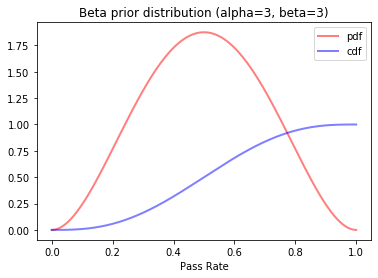

In [28]:
# weakly informative prior

import scipy.stats as ss

def plot_beta(x_range, a, b, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the f distribution function for a given x range, a and b
    If mu and sigma are not provided, standard beta is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.beta.cdf(x, a, b, mu, sigma)
    else:
        y = ss.beta.pdf(x, a, b, mu, sigma)
    plt.plot(x, y, **kwargs)
    
x = np.linspace(0, 1, 2000)

plot_beta(x, 3, 3, 0, 1, color='red', lw=2, ls='-', alpha=0.5, label='pdf')
plot_beta(x, 3, 3, 0, 1, cdf=True, color='blue', lw=2, ls='-', alpha=0.5, label='cdf')
plt.title("Beta prior distribution (alpha=3, beta=3)")
plt.xlabel("Pass Rate")
plt.legend();
plt.savefig('./figures/beta33.png')

In [29]:
pbp.isnull().sum(axis=0)

play_id       0
game_id       0
home_team     0
away_team     0
posteam       0
             ..
is_home       0
half          0
season        0
week          0
head_coach    0
Length: 261, dtype: int64

In [30]:
pbp.loc[:,'play_type'] = pbp.play_type.copy().replace({"run":"0","pass":"1"}).astype(int)

Instead of ML models I'll use pymc3 to estimate the base rate.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pct_pass]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:01<00:00, 6506.31draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15c1c60d0>,
      dtype=object)

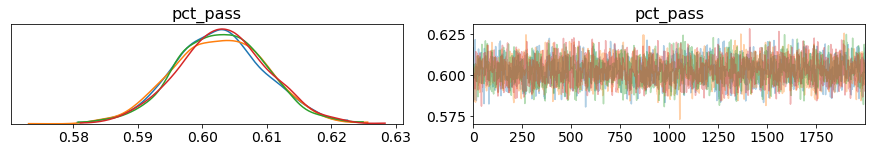

In [31]:
import pymc3 as pm

data = pbp[['head_coach','yards_for_td','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

# shuffle data 
data = data.sample(frac=1)

# only need 5000 observations
data = data[:5000]

plays = data.play_type.values
n = len(plays)


with pm.Model() as model:
    pct_pass = pm.Beta('pct_pass', alpha=3, beta=3)
    y = pm.Bernoulli('likelihood', p=pct_pass, observed=plays)
    
    trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')
    
trarr = pm.traceplot(trace, var_names=['pct_pass'])

fig = plt.gcf() # to get the current figure...
fig.savefig("./figures/base_pass_rate.png") # and save it directly

trarr


In [32]:
print(pbp.score_differential.quantile(0.05))
print(pbp.score_differential.quantile(0.95))

-20.0
17.0


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:11<00:00, 1050.91draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15822d5d0>,
      dtype=object)

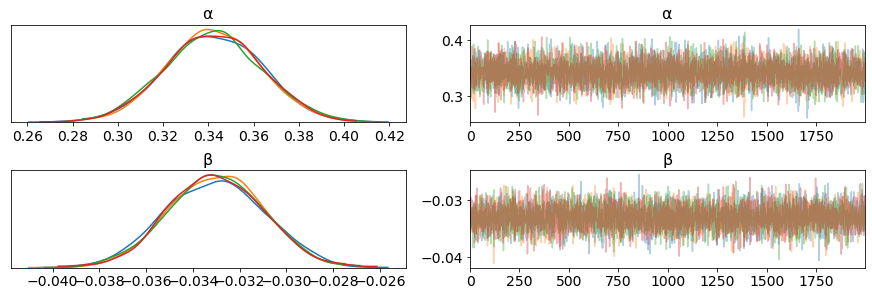

In [33]:
data = pbp[['score_differential','play_type']]

# shuffle data 
data = data.sample(frac=1)

# let's use 10,000 observations
data = data[:10000]

plays = data.play_type.values
covariate = data.score_differential.values
n = len(plays)

with pm.Model() as model:
    
    # priors
    α = pm.StudentT('α',nu=6,mu=0,sigma=4)
    β  = pm.StudentT('β',nu=6,mu=0,sigma=4)
    
    # linear regression, the engine behind logistic regression
    μ = α + β * covariate
    
    # link function theta - necessary for modeling Binary outcomes
    θ = pm.Deterministic('θ', pm.math.invlogit(μ))
    
    # observed/target
    y = pm.Bernoulli('y', p=θ, observed=plays)
    
    trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')
    
trarr = pm.traceplot(trace, var_names=['α','β'])

fig = plt.gcf() 
fig.savefig("./figures/one_covariate_trace.png") 

trarr


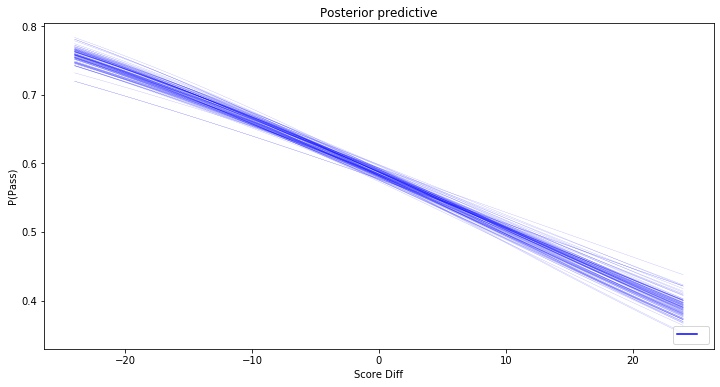

In [34]:
def lm_full(trace, score_diff):
    shape = np.broadcast(score_diff).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [score_diff]])
    # return inverse logit
    return 1 / (1 + np.exp(-(trace['α'] + 
                             trace['β']*x_norm[0])))

samples=1000
x = np.linspace(-17, 17, samples)

lm = lambda x, trace: lm_full(trace, x)

fig = plt.figure(figsize=(12,6))
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm, samples=100, color='blue', alpha=.5)

import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b')
plt.legend(handles=[blue_line], loc='lower right')
plt.ylabel("P(Pass)")
plt.xlabel("Score Diff")
plt.savefig("./figures/score_diff.png")
plt.show()


In [35]:
# coach game count
data = pbp[['head_coach','score_differential','play_type']]

data.groupby(['head_coach'])['play_type'].count().reset_index().sort_values(by=['play_type'],ascending=False).head(10)

,head_coach,play_type
5,Bill Belichick,12090
44,John Harbaugh,11729
66,Mike Tomlin,11364
2,Andy Reid,11147
80,Sean Payton,10702
53,Marvin Lewis,10254
72,Pete Carroll,10167
58,Mike McCarthy,10143
31,Jason Garrett,9800
43,John Fox,9374


In [36]:
head_coaches = ['Bill Belichick','John Harbaugh','Mike Tomlin','Andy Reid','Sean Payton','Marvin Lewis','Pete Carroll','Mike McCarthy','Jason Garrett','John Fox']


In [37]:
data = pbp[['head_coach','score_differential','play_type']]
pc_ranks = data.groupby(['head_coach'])['play_type'].mean().reset_index().sort_values(by=['play_type'],ascending=False)

pc_ranks.head(50)



,head_coach,play_type
0,Aaron Kromer,0.727794
75,Rob Chudzinski,0.680075
9,Brian Flores,0.667954
28,Gus Bradley,0.641988
34,Jim Caldwell,0.641970
91,Zac Taylor,0.640952
52,Marc Trestman,0.638016
47,Ken Whisenhunt,0.637659
37,Jim Schwartz,0.633667
40,Joe Philbin,0.631964


In [38]:
pc_ranks.play_type.std()

0.03617997746386621

In [51]:
# data = pbp[['season','week','head_coach','passer_player_name','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

data = pbp[['season','week','head_coach','passer_player_name','score_differential','down','distance','play_type']]
data = data.loc[data.head_coach.isin(['Andy Reid'])]

# keep data balanced by only taking roughly last 1500 reid plays before mahomes
data = data.sort_values(by=['season','week'],ascending=[False,False])
data = data[:2250]

# shuffle data 
data = data.sample(frac=1)

print("These coaches combined for {} plays in the dataset".format(len(data)))

data.loc[data.passer_player_name!='P.Mahomes', 'passer_player_name'] = 0
data.loc[data.passer_player_name=='P.Mahomes', 'passer_player_name'] = 1

# data.loc[data.passer_player_name!='J.Garoppolo', 'passer_player_name'] = 0
# data.loc[data.passer_player_name=='J.Garoppolo', 'passer_player_name'] = 1

data = data.rename(columns={'passer_player_name':'qb'})

print(data.groupby(['qb'])['play_type'].count())



These coaches combined for 2250 plays in the dataset
qb
0    1113
1    1137
Name: play_type, dtype: int64


In [ ]:
# size of covariate vector
D = 3

# number of plays/samples
N = len(data)

# number of categories -- right now just mahomes or not mahomes
L = 2

# 0 = run, 1 = pass
y = data.play_type.values

# pat or not pat
ll = data.qb.values

# covariates
x = data[['score_differential','down','distance']].values



In [ ]:
model_code = """
data {
  int<lower=1> D;
  int<lower=0> N;
  int<lower=1> L;
  int<lower=0,upper=1> y[N];
  int<lower=1,upper=L> ll[N];
  row_vector[D] x[N];
}
parameters {
  real mu[D];
  real<lower=0> sigma[D];
  vector[D] beta[L];
}
model {
  for (d in 1:D) {
    mu[d] ~ normal(0, 100);
    for (l in 1:L)
      beta[l,d] ~ normal(mu[d], sigma[d]);
  }
  for (n in 1:N)
    y[n] ~ bernoulli_logit(x[n] * beta[ll[n]]);
}
"""

In [ ]:
sm = pystan.StanModel(model_code=model_code)
fit = sm.sampling(data=play_data)



In [ ]:
# play_data = pd.D

# model_code = """
# data {
#   int<lower=0> J;
#   real y[J];
#   real<lower=0> sigma[J];
# }

# parameters {
#   real mu;
#   real<lower=0> tau;
#   real theta_tilde[J];
# }

# transformed parameters {
#   real theta[J];
#   for (j in 1:J)
#     theta[j] = mu + tau * theta_tilde[j];
# }

# model {
#   mu ~ normal(0, 5);
#   tau ~ cauchy(0, 5);
#   theta_tilde ~ normal(0, 1);
#   y ~ normal(theta, sigma);
# }
# """

# sm = pystan.StanModel(model_code=stan_code)
# fit = sm.sampling(data=play_data)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [qb_b, qb_a, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [02:24<00:00, 180.27draws/s]
The acceptance probability does not match the target. It is 0.8268737340008602, but should be close to 0.925. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1632804d0>,
      dtype=object)

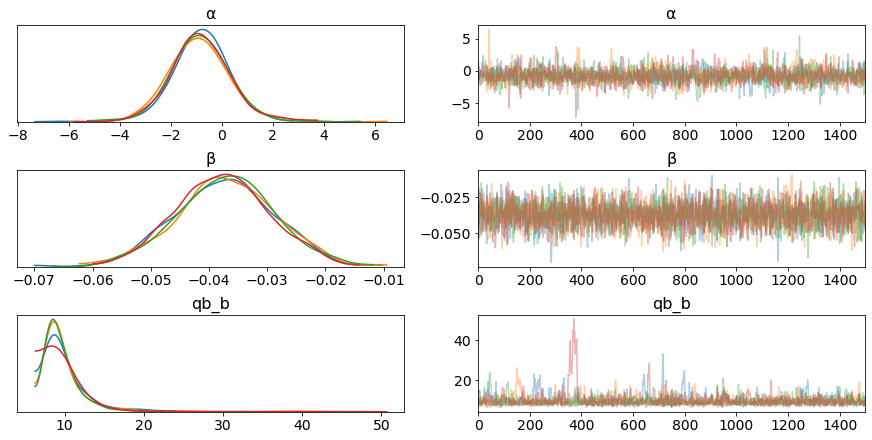

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13dffd3d0>,
      dtype=object)

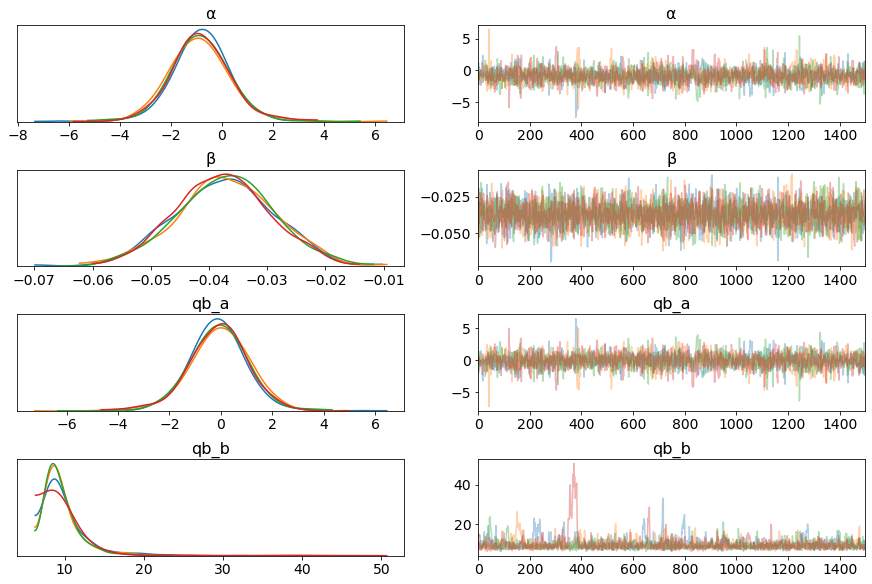

In [69]:
trarr = pm.traceplot(trace, var_names=['α','β','qb_a','qb_b'])

fig = plt.gcf() 
fig.savefig("./figures/qb_trace.png") 

trarr

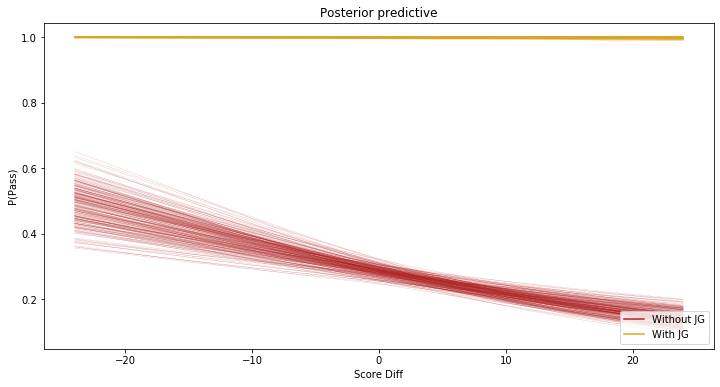

In [66]:
def lm_full(trace, score_diff, qb):
    shape = np.broadcast(score_diff, qb).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [score_diff,qb]])
    # return inverse logit
    return 1 / (1 + np.exp(-(trace['α'] + 
                             trace['β']*x_norm[0])+
                           trace['qb_a'] +
                           trace['qb_b']*x_norm[1]))

samples=1000
x = np.linspace(-17, 17, samples)

lm0 = lambda x, trace: lm_full(trace, x, 0)
lm1 = lambda x, trace: lm_full(trace, x, 1)
# lm2 = lambda x, trace: lm_full(trace, x, 2)
# lm3 = lambda x, trace: lm_full(trace, x, 3)

fig = plt.figure(figsize=(12,6))
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm0, samples=250, color='firebrick', alpha=.5)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm1, samples=250, color='goldenrod', alpha=.5)
# pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm2, samples=250, color='lime', alpha=.5)
# pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm3, samples=250, color='deepskyblue', alpha=.5)

import matplotlib.lines as mlines
andy = mlines.Line2D(['lm0'], [], color='firebrick', label='Without JG')
kyle = mlines.Line2D(['lm1'], [], color='goldenrod', label='With JG')
# bill = mlines.Line2D(['lm2'], [], color='lime', label='Pete Carroll')
# mike = mlines.Line2D(['lm3'], [], color='deepskyblue', label='Mike Vrabel')

plt.legend(handles=[andy,kyle], loc='lower right')
plt.ylabel("P(Pass)")
plt.xlabel("Score Diff")
plt.savefig("./figures/jg_comparison.png")
plt.show()

In [42]:
print(list(pbp))

['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yards_for_td', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob'

In [43]:
# front fill qb 
data = pbp[['head_coach','season','week','game_seconds_remaining','passer_player_name','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

data = data.sort_values(by=['head_coach','season','week','game_seconds_remaining'], ascending=[True,True,True,False])

data.passer_player_name = data.passer_player_name.copy().fillna(method='ffill')

data


,head_coach,season,week,game_seconds_remaining,passer_player_name,ydstogo,down,half,half_seconds_remaining,score_differential,play_type
98426,Aaron Kromer,2012,1,3600.0,D.Brees,10,1.0,0,1800.0,0.0,1
98427,Aaron Kromer,2012,1,3597.0,D.Brees,10,2.0,0,1797.0,0.0,1
98428,Aaron Kromer,2012,1,3592.0,D.Brees,10,3.0,0,1792.0,0.0,1
98440,Aaron Kromer,2012,1,3125.0,D.Brees,10,1.0,0,1325.0,-3.0,0
98441,Aaron Kromer,2012,1,3091.0,D.Brees,4,2.0,0,1291.0,-3.0,1
...,...,...,...,...,...,...,...,...,...,...,...
361591,Zac Taylor,2019,17,306.0,A.Dalton,10,1.0,1,306.0,7.0,0
361592,Zac Taylor,2019,17,262.0,A.Dalton,4,2.0,1,262.0,7.0,0
361593,Zac Taylor,2019,17,214.0,A.Dalton,10,1.0,1,214.0,7.0,0
361594,Zac Taylor,2019,17,170.0,A.Dalton,12,2.0,1,170.0,7.0,0


In [44]:
# interested in andy reid with pat, andy reid without pat, ks w/ jg, w/o, and control
sample = data.loc[data.head_coach.isin(['Andy Reid', 'Kyle Shanahan'])]
sample_len = len(sample)
print(sample_len)

sample.groupby(['head_coach','passer_player_name'])['play_type'].count()



14261


head_coach     passer_player_name
Andy Reid      A.Smith               4651
               B.Westbrook              3
               C.Daniel               155
               C.Henne                 11
               D.McNabb               789
               D.Poe                    2
               J.Maclin                 3
               K.Kolb                 505
               M.Kafka                 18
               M.Moore                160
               M.Vick                2182
               N.Foles                533
               P.Mahomes             1920
               S.Darnold                2
               T.Bray                   1
               T.Edwards                5
               T.Hill                   2
               T.Kelce                  4
               V.Young                201
Kyle Shanahan  B.Hoyer                348
               C.Beathard             712
               D.Pettis                 1
               E.Sanders                1


In [45]:
control = data.loc[~data.head_coach.isin(['Andy Reid', 'Kyle Shanahan'])]
control = control.sample(frac=1)
control = control[:(sample_len)]
control.groupby(['head_coach'])['play_type'].count().reset_index().sort_values(by=['play_type'], ascending=False)



,head_coach,play_type
4,Bill Belichick,487
43,John Harbaugh,467
64,Mike Tomlin,465
78,Sean Payton,459
51,Marvin Lewis,429
...,...,...
0,Aaron Kromer,19
55,Mel Tucker,18
21,Eric Studesville,11
26,Gregg Williams,10


In [46]:
# transform into "pat or not pat"
sample['hc_p'] = np.nan
sample.loc[(sample.head_coach=='Andy Reid')&(sample.passer_player_name=='P.Mahomes'), 'hc_p'] = 0
sample.loc[(sample.head_coach=='Andy Reid')&(sample.passer_player_name!='P.Mahomes'), 'hc_p'] = 1
sample.loc[(sample.head_coach=='Kyle Shanahan')&(sample.passer_player_name=='J.Garoppolo'), 'hc_p'] = 2
sample.loc[(sample.head_coach=='Kyle Shanahan')&(sample.passer_player_name!='J.Garoppolo'), 'hc_p'] = 3
control['hc_p'] = 4




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [47]:
data = pd.concat([sample, control], axis=0)
print(len(data))
data.head()

28522


,head_coach,season,week,game_seconds_remaining,passer_player_name,ydstogo,down,half,half_seconds_remaining,score_differential,play_type,hc_p
879,Andy Reid,2009,1,3108.0,S.Darnold,10,1.0,0,1308.0,-7.0,0,1.0
880,Andy Reid,2009,1,3078.0,S.Darnold,6,2.0,0,1278.0,-7.0,0,1.0
881,Andy Reid,2009,1,3017.0,D.McNabb,9,3.0,0,1217.0,-7.0,1,1.0
882,Andy Reid,2009,1,2975.0,D.McNabb,10,1.0,0,1175.0,-7.0,1,1.0
883,Andy Reid,2009,1,2967.0,D.McNabb,10,2.0,0,1167.0,-7.0,0,1.0


In [48]:
data.groupby(['hc_p'])['play_type'].mean()

hc_p
0.0    0.640625
1.0    0.592934
2.0    0.535737
3.0    0.621397
4.0    0.588318
Name: play_type, dtype: float64

In [49]:
data = data.sample(frac=1)

X = patsy.dmatrix("1 + score_differential", data=data, return_type='dataframe')
X = np.asarray(X)
print(X.shape[1])

Z = patsy.dmatrix('0 + hc_p', data=data, return_type='dataframe')
Z = np.asarray(Z)

# Z_slope = patsy.dmatrix('0 + hc_p', data=data, return_type='dataframe')
# Z_slope = np.asarray(Z_slope)

# Z = np.concatenate((Z_intercept, Z_slope), axis=1)

# print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
# print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Y = np.asarray(data['play_type'])


2
Z has shape (28522, 1)


In [50]:
###### 
CHAINS = 2
CORES = 4
TUNE = 1000
DRAWS = 1000
BURNIN = 1000


In [51]:

with pm.Model() as model:
    
    beta_X_intercept = pm.Normal('beta_X_intercept', sd=100) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)

    sigma_Z = pm.Normal('sigma_Z', sd=100) 

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    
    θ = pm.math.invlogit(estimate)
    
    ## likelihood
    y_likelihood = pm.Bernoulli('y_likelihood', p=θ, observed=Y)
    
    advi = pm.ADVI()
    
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval  # callable that returns std
    )
    
    approx = advi.fit(750000, callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute'),tracker])
    
    

Average Loss = 18,996:  18%|█▊        | 137673/750000 [07:13<32:09, 317.33it/s]  
Interrupted at 137,699 [18%]: Average Loss = 21,465


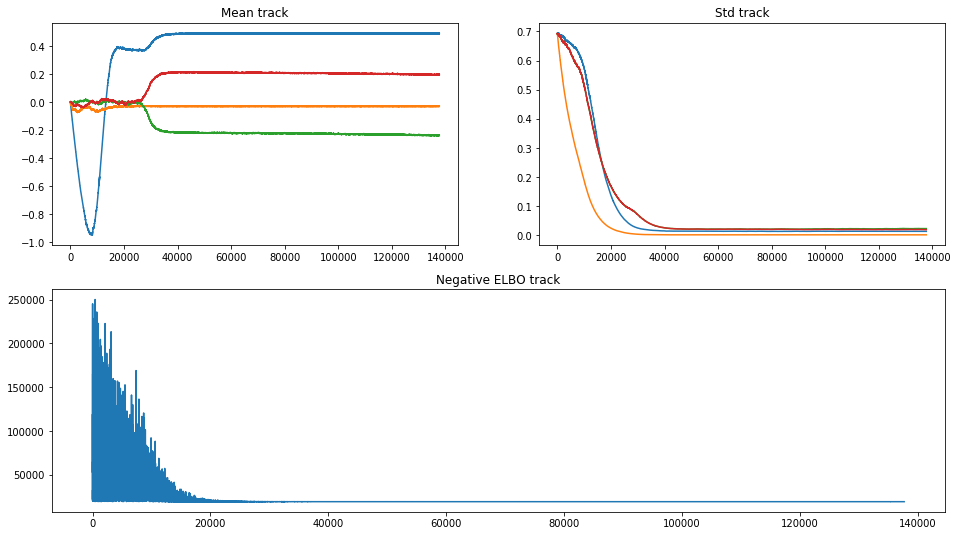

In [52]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');
plt.savefig("./figures/local_minima.png")

ValueError: not enough values to unpack (expected 2, got 1)

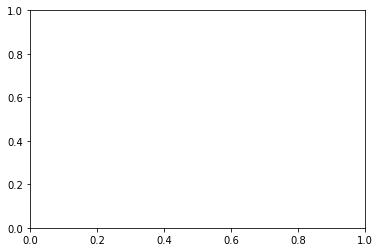

In [53]:

# sns.kdeplot(approx.sample(5000)['beta_X_intercept'])

sns.kdeplot(approx.sample(5000)['gamma_Z'])

# print(approx.sample(5000))


In [ ]:
# data = data[['hc-p','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

# # shuffle data 
# data = data.sample(frac=1)

# print("These coaches combined for {} plays in the dataset".format(len(data)))

# le = LabelEncoder()
# le.fit(data.head_coach)

# data.loc[:,'i_head_coach'] = le.transform(data.head_coach.copy())
# print("there are {} head coaches in the dataset".format(data.i_head_coach.max()))

# ytg_t = pm.Minibatch(data.ydstogo.values, 5600)
# down_t = pm.Minibatch(data.down.values, 5600)
# half_t = pm.Minibatch(data.half.values, 5600)
# hsec_t = pm.Minibatch(data.half_seconds_remaining.values, 5600)
# sdiff_t = pm.Minibatch(data.score_differential.values, 5600)
# idx = pm.Minibatch(data['hc-p'].astype(int).values, 5600)
# plays_t = pm.Minibatch(data.play_type.values, 5600)

# ytg_t = data.ydstogo.values
# down_t = data.down.values
# half_t = data.half.values
# hsec_t = data.half_seconds_remaining.values
# sdiff_t = data.score_differential.values
# idx = data['hc-p'].astype(int).values
# plays_t = data.play_type.values

# num_cs = len(data['hc-p'].unique())
# n = len(plays)


# with pm.Model() as model:
    
#     sd_coach = pm.HalfCauchy('sd_coach',beta=10)
    
#     cfe = pm.Normal("cfe", mu=0, sigma=sd_coach, shape=num_cs)
    
#     cs = pm.Deterministic('cs', cfe - tt.mean(cfe))
    
#     # priors
#     intercept = pm.StudentT('intercept',nu=3,mu=0,sigma=10)
    
#     ytg_b  = pm.StudentT('ytg_b',nu=3,mu=0.1,sigma=2)
#     down_b  = pm.StudentT('down_b',nu=3,mu=1,sigma=2)
#     half_b = pm.StudentT('half_b',nu=3,mu=1,sigma=2)
#     hsec_b  = pm.StudentT('hsec_b',nu=3,mu=0,sigma=0.1)
#     sdiff_b  = pm.StudentT('sdiff_b',nu=3,mu=0,sigma=1)
    
#     # player coach effect
#     pce = pm.StudentT('pce',nu=3,mu=16,sigma=20)
    
#     μ = intercept + ytg_b*ytg_t + down_b*down_t + half_b * half_t + hsec_b*hsec_t + sdiff_b*sdiff_t + cs[idx] * pce
    
#     # link function theta - necessary for modeling Binary outcomes
#     θ = pm.Deterministic('θ', pm.math.invlogit(μ))
    
#     # observed/target
#     y = pm.Bernoulli('y', p=θ, observed=plays_t, total_size=n)
    
# #     trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')
#     advi = pm.ADVI()
    
#     tracker = pm.callbacks.Tracker(
#         mean=advi.approx.mean.eval,  # callable that returns mean
#         std=advi.approx.std.eval  # callable that returns std
#     )
    
# #      obj_optimizer=pm.adagrad(learning_rate=.01), 

#     approx = advi.fit(1200000, callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute'),tracker])
    

In [ ]:
# data = pbp[['head_coach','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

# data = data[:5000]

# ytg_t = data.ydstogo.values
# down_t = data.down.values
# half_t = data.half.values
# hsec_t = data.half_seconds_remaining.values
# sdiff_t = data.score_differential.values
# plays_t = data.play_type.values
# # idx = data.i_head_coach.values

# with pm.Model() as model:
    
# #     cfe = pm.Normal("cfe", mu=0, sigma=0.036, shape=num_cs)
    
    
# #     cs = pm.Deterministic('cs', cfe - tt.mean(cfe))
    
#     # priors
#     intercept = pm.StudentT('intercept',nu=3,mu=0,sigma=10)
    
#     ytg_b  = pm.StudentT('ytg_b',nu=3,mu=0.1,sigma=1)
#     down_b  = pm.StudentT('down_b',nu=3,mu=1,sigma=1)
#     half_b = pm.StudentT('half_b',nu=3,mu=1,sigma=2)
#     hsec_b  = pm.StudentT('hsec_b',nu=3,mu=0,sigma=0.01)
#     sdiff_b  = pm.StudentT('sdiff_b',nu=3,mu=0,sigma=0.1)
    
#     μ = intercept + ytg_b*ytg_t + down_b*down_t + half_b*half_t +hsec_b*hsec_t + sdiff_b*sdiff_t #+ cs[idx]
    
#     # link function theta - necessary for modeling Binary outcomes
#     θ = pm.Deterministic('θ', pm.math.invlogit(μ))
    
#     # observed/target
#     y = pm.Bernoulli('y', p=θ, observed=plays_t, total_size=n)
    
#     trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')

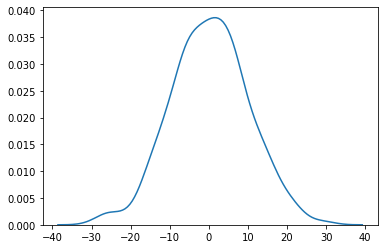

In [59]:

# ax = sns.kdeplot(trace['down_b']);
# sns.kdeplot(trace['cs'][0], label='A Reid W/ Pat', color='red');
# sns.kdeplot(trace['cs'][1], label='A Reid W/O Pat', color='green');

# sns.kdeplot(approx.sample(5000)['cs'][0], label='A Reid W/ Pat', color='red');
# sns.kdeplot(approx.sample(5000)['cs'][1], label='A Reid W/O Pat', color='green');
# sns.kdeplot(approx.sample(5000)['cs'][4], label='League', color='black');

# pm.traceplot(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained'])

# sns.kdeplot(approx.sample(1000)['beta_X_intercept'])




In [67]:
le.inverse_transform([4])

array(['John Harbaugh'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x148fe5c10>,
      dtype=object)

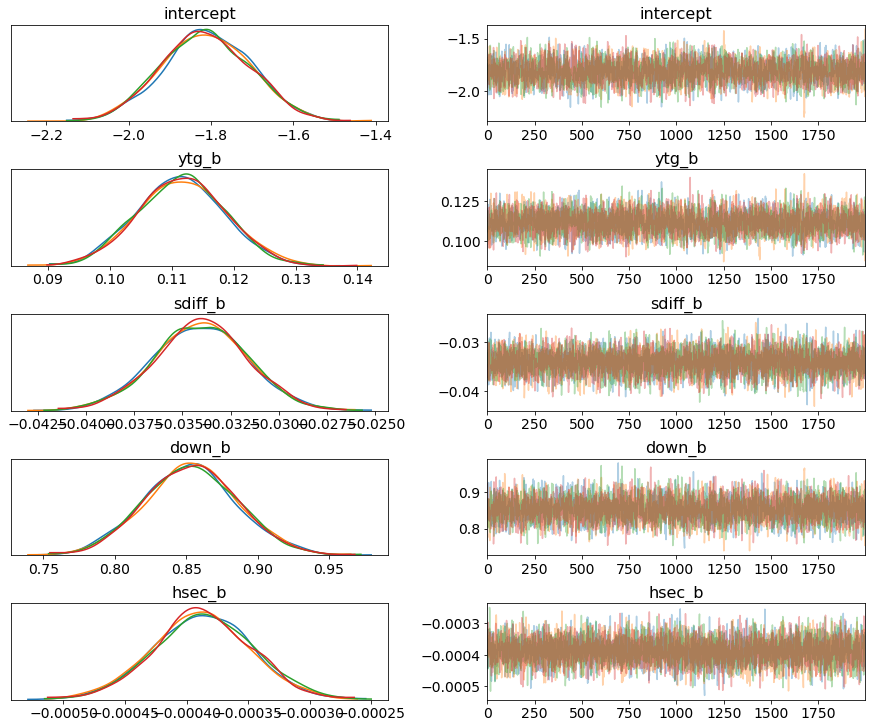

In [46]:
trarr = pm.traceplot(trace, var_names=['intercept','ytg_b','sdiff_b','down_b','hsec_b'])

fig = plt.gcf() 
fig.savefig("./figures/vars_trace.png") 

trarr

In [ ]:
print(le.classes_)
le.transform(["Mike Vrabel","Kliff Kingsbury"])

In [ ]:
def lm_full(trace, score_diff, coach):
    shape = np.broadcast(score_diff, coach).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [score_diff,coach]])
    # return inverse logit
    return 1 / (1 + np.exp(-(trace['α'] + 
                             trace['sdiff_b']*x_norm[0])-trace['coach'][coach]*x_norm[1]))

samples=1000
x = np.linspace(-17, 17, samples)

lm0 = lambda x, trace: lm_full(trace, x, 67)
lm1 = lambda x, trace: lm_full(trace, x, 48)
# lm2 = lambda x, trace: lm_full(trace, x, 2)
# lm3 = lambda x, trace: lm_full(trace, x, 3)

fig = plt.figure(figsize=(12,6))
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm0, samples=250, color='cyan', alpha=.5)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm1, samples=250, color='red', alpha=.5)
# pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm2, samples=250, color='lime', alpha=.5)
# pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm3, samples=250, color='deepskyblue', alpha=.5)

import matplotlib.lines as mlines
mike = mlines.Line2D(['lm0'], [], color='cyan', label='Mike Vrabel')
kliff = mlines.Line2D(['lm1'], [], color='red', label='Kliff Kingsbury')
# bill = mlines.Line2D(['lm2'], [], color='lime', label='Pete Carroll')
# mike = mlines.Line2D(['lm3'], [], color='deepskyblue', label='Mike Vrabel')

plt.legend(handles=[mike,kliff], loc='lower right')
plt.ylabel("P(Pass)")
plt.xlabel("Score Diff")
plt.savefig("./figures/coach_comparison_2.png")
plt.show()

In [ ]:
# data = pbp[['head_coach','yards_for_td','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

# le = LabelEncoder()
# le.fit(data.head_coach)

# data.loc[i_head_coach] = le.transform(data.head_coach.copy())
# print("there are {} head coaches in the dataset".format(data.head_coach.max()))

# coach_ids = data[['head_coach']]
# coach

# covariate = data.score_differential.values
# plays = data.play_type.values
# n = len(plays)

    
    



                              
# with pm.Model() as model:
#     pm.glm.GLM.from_formula('play_type ~ head_coach + yards_for_td + ydstogo + down + half + half_seconds_remaining + score_differential',
#                             data,
#                             family=pm.glm.families.Binomial())
#     trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')


# stan_code = """

# data{
#     int<lower=1> I; //number features
#     int<lower=1> N; //number plays
    
#     matrix[N, I] X;
    
#     int<lower=0, upper=1> y[N]; // target
# }

# parameters{
#     vector[I] beta;
#     real alpha; // intercept, as in traditional linear regression
# }

# //transformed parameters{
# //}

# model{
#     // covariate priors (essentially ignorant)
#     beta ~ normal(0,10);
#     alpha ~ normal(0,10);
    
#     // "bernoulli logit" is special stan syntax that speeds up processing
#     y ~ bernoulli_logit(X * beta + alpha); // linear function, inside link function 
# }

# """

# play_data = {
#     'I':X.shape[1],
#     'N':len(mdf),
#     'X':X,
#     'y':plays
# }


# sm = pystan.StanModel(model_code=stan_code)
# fit = sm.sampling(data=play_data)


In [ ]:
# trarr = pm.traceplot(trace, var_names=['α','β'])

# fig = plt.gcf() # to get the current figure...
# fig.savefig("./figures/simple_logit.png") # and save it directly

# pm.traceplot(trace, var_names=['α','β'])

In [ ]:
# p = trace.get_values('p', burn=niter//2, combine=True, chains=[0,4])
# pm.traceplot(trace, var_names=['p'])

In [ ]:
# le.classes_

In [ ]:
# df_hpd = pd.DataFrame(pm.stats.hpd(trace['head_coach']),
#                       columns=['hpd_low', 'hpd_high'],
#                       index=le.classes_)
# df_median = pd.DataFrame(np.quantile(trace['head_coach'], 0.5, axis=0),
#                          columns=['hpd_median'],
#                          index=le.classes_)
# df_hpd = df_hpd.join(df_median)
# df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
# df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
# df_hpd = df_hpd.sort_values(by='hpd_median')
# df_hpd = df_hpd.reset_index()
# df_hpd['x'] = df_hpd.index + .5


# fig, axs = plt.subplots(figsize=(13,7))
# axs.errorbar(df_hpd.x, df_hpd.hpd_median,
#              yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
#              fmt='o')
# axs.set_title('CI of QB Touchdown Expectation')
# axs.set_xlabel('Team')
# axs.set_ylabel('Posterior QB Touchdown Expectation')
# _= axs.set_xticks(df_hpd.index + .5)
# _= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

# plt.savefig('./figures/CI_HC.png')